In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../..")

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian, generate_total_hamiltonian, \
                                            generate_reduced_X_hamiltonian, generate_reduced_B_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator, \
                            check_approx_state_exact_state
from couplings.generate_coupling import optical_coupling_matrix, microwave_coupling_matrix, \
                                        generate_laser_D, generate_microwave_D,\
                                        generate_coupling_field

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

from hamiltonian.generate_states import generate_ground_states_approx, generate_excited_states_approx

In [2]:
script_dir = Path().parent.absolute().parent.parent
script_dir

WindowsPath('C:/Users/Olivier/Documents/GitHub/optical-bloch')

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Jg = [0,2]
#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = generate_ground_states_approx(Jg)

ground_states, H_X_red = generate_reduced_X_hamiltonian(ground_states_approx)

In [4]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P 

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [5]:
# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1]
F1_excited = [3/2]
F_excited = [1]

excited_states_approx = generate_excited_states_approx(J_excited, F_excited, F1_excited, P=-1)

excited_states, H_B_red = generate_reduced_B_hamiltonian(excited_states_approx)

In [6]:
for s in excited_states_approx:
    s.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

## Total Internal Hamiltonian

In [7]:
H_int, V_ref_int = generate_total_hamiltonian(H_X_red, H_B_red)
#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition P(2) F'=1 F1'=3/2

In [8]:
#Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  generate_ground_states_approx(Js)

#Define excited states for laser
excited_states_laser_approx = excited_states_approx

#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=2,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**2, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)

In [9]:
%%time
laser_couplings = generate_coupling_field(ground_main_approx, excited_main_approx, 
                                        ground_states_laser_approx, excited_states_laser_approx,
                                        H_rot, QN, V_ref_int, pol_main = np.array([0,0,1]),
                                        pol_vec = [np.array([0,0,1]), np.array([1,0,0])],
                                        nprocs = 6)

Wall time: 26.1 s


In [10]:
D1 = generate_laser_D(H_rot, QN, 
                      laser_couplings[0]['ground_main'], laser_couplings[0]['excited_main'], 
                      laser_couplings[0]['excited_states'], Δ = 0)

## Total Hamiltonian

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
[-2.51351302e+11 -2.51351386e+11 -2.51351386e+11 -2.51351386e+11
 -2.79730217e+05 -2.79720191e+05 -2.79710164e+05  8.37155151e+00
  4.18627930e+00  0.00000000e+00 -4.18640137e+00 -8.37411499e+00
  1.75182816e+06  1.75182875e+06  1.75182933e+06  1.75182992e+06
  1.75183051e+06  1.97313650e+06  1.97312964e+06  1.97312277e+06
  1.97311590e+06  1.97310903e+06  1.97310217e+06  1.97309530e+06
 -6.28314209e+00  0.00000000e+00  6.28335571e+00]


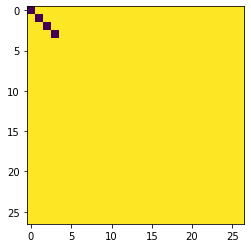

In [11]:
gnd_idx = QN.index(laser_couplings[0]['ground_main'])
H_rot = H_int.copy()
H_rot = H_rot - np.eye(H_rot.shape[0])*H_rot[gnd_idx,gnd_idx]
H_rot = H_rot + D1
plt.imshow(H_rot.real)
print(np.diag(H_rot.real))

In [12]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


In [13]:
t = Symbol("t", real = True)
Plx = Symbol("Plx") # Polarization switching function for x
Plz = Symbol("Plz") # Polarization switching function for z

laser_fields = [(laser_couplings[0]['field']*Plz, laser_couplings[0]['main_coupling']), 
                (laser_couplings[1]['field']*Plx, laser_couplings[1]['main_coupling'])]
detunings = [[QN.index(exc) for exc in laser_couplings[0]['excited_states']]]

In [14]:
n_states = H_rot.shape[0]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [15]:
Ωl = Symbol('Ωl', real = True)
Ωlc = Symbol('Ωlᶜ', real = True)
H_symbolic = H_symbolic.subs(Ωs[0][0],Ωl).subs(Ωs[0][1],Ωlc)
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωl).subs(Ωs[1][1],Ωlc)

# H_symbolic

In [16]:
%%time
system = generate_system_of_equations(H_symbolic, C_array, progress = False, fast = True)

Wall time: 7.9 s


In [17]:
%%time
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system, nprocs = 6)

Wall time: 12.4 s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [18]:
# import julia
# julia.install()

In [19]:
from julia import Main

In [20]:
nprocs = 6

Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

using Distributed
using BenchmarkTools
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("../../utils/general_ode_functions.jl")
end
""")

print(Main.eval("procs()"))

[1 2 3 4 5 6]


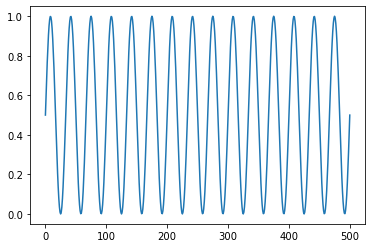

In [21]:
ti = np.linspace(0,300e-6,501)
plt.plot((np.sin(2*np.pi*5e4*ti)+1)/2)

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [22]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tΔ = p[2]
\t\tνmp = p[3]
\t\tΩlᶜ = conj(Ωl)

\t\tΩt = (sin(2π*νmp*t) + 1)/2
\t\tPlx = p[4]*Ωt
\t\tPlz = p[5]*Ωt
"""

In [23]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ωl = p[1]
		Δ = p[2]
		νmp = p[3]
		Ωlᶜ = conj(Ωl)

		Ωt = (sin(2π*νmp*t) + 1)/2
		Plx = p[4]*Ωt
		Plz = p[5]*Ωt



In [24]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [25]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

### Generate density matrix

In [26]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [27]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [28]:
T = 6.3
ρ_ini = np.zeros(H_rot.shape, dtype = 'complex')

index = 0
for J in [0,2]:
    p = population(J, T)
    levels = J_levels(J)
    sl = np.s_[index:index+levels]
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)
    index += levels

ρ_ini /= np.diag(ρ_ini).sum()

In [29]:
Γ = 2*np.pi * 1.56e6


Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ωl = Γ
    Δ = 0
    νmp = 5e4
    p = [Ωl, Δ, νmp, 0, 1]
end
""")

In [30]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 21.9 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [31]:
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [32]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false);
tmp = 0
""");

Wall time: 12.3 s


0

In [33]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

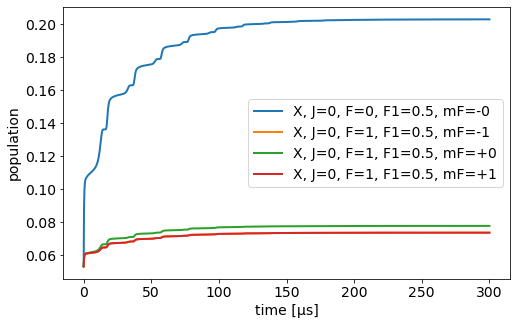

In [34]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in [0,1,2,3]:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

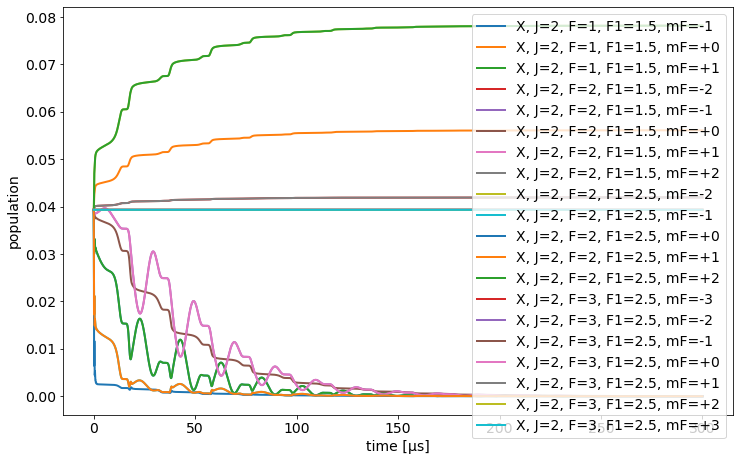

In [35]:
fig, ax = plt.subplots(figsize = (12,7.5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(4,24):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [36]:
p = pop_results[-10:-3].sum(axis = 0)
print(f'accumulation J=2 F=3 : {p[-1]/p[0]:.2f}')

accumulation J=2 F=3 : 1.00


In [37]:
p = pop_results[[0]].sum(axis = 0)
print(f'accumulation J=0 F=0 : {p[-1]/p[0]:.2f}')

accumulation J=0 F=0 : 3.80


In [38]:
p = pop_results[1:4].sum(axis = 0)
print(f'accumulation J=0 F=1 : {p[-1]/p[0]:.2f}')

accumulation J=0 F=1 : 1.41


In [39]:
np.diag(ρ_ini)[:4]

array([0.05334403+0.j, 0.05334403+0.j, 0.05334403+0.j, 0.05334403+0.j])

In [40]:
pop_results[:4,-1]

array([0.20282085, 0.07378288, 0.07788119, 0.07378284])

In [41]:
ρ_rc = np.zeros(ρ_ini.shape, dtype = complex)
p = population(2, T)
levels = J_levels(2)
np.fill_diagonal(ρ_rc[4:24,4:24], p/levels)
ρ_rc /= np.diag(ρ_rc).sum()
Main.ρ_rc = ρ_rc

In [42]:
Main.eval("""
tspan = (0.0, 300e-6)
prob_rc = ODEProblem(Lindblad_rhs!,ρ_rc,tspan,p)
""");

In [43]:
%%time
Main.eval("""
@time sol_rc = solve(prob_rc, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false);
tmp = 0
""");

Wall time: 209 ms


0

In [44]:
ut = np.array(Main.eval("sol_rc[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol_rc.t")

In [45]:
pop_results[:,-1][4:24]

array([5.60230762e-06, 7.13290619e-02, 5.57796464e-06, 5.33192432e-02,
       8.93335284e-06, 1.98319002e-05, 8.88203605e-06, 5.33192913e-02,
       9.93983614e-02, 1.66602517e-06, 1.33433047e-06, 1.65892069e-06,
       9.93981545e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02])

In [46]:
pop_results[:,-1][:4]

array([0.19002323, 0.025983  , 0.031193  , 0.02598295])

## Scan Rabi Rate

In [47]:
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [48]:
Main.params = np.linspace(0,1,201)*Main.Γ
Main.eval("@everywhere params = $params")

In [49]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    if size(sol.u)[1] != 2
        return NaN, false
    else
        val = [real(sol.u[2][1,1])/real(sol.u[1][1,1]),
               sum(real(diag(sol.u[2])[2:4]))/sum(real(diag(sol.u[1])[2:4]))]
        return val, false
    end
end""")

In [50]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [params[i], 0, νmp, 0, 1])
end
""")

In [51]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [52]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-9, reltol = 1e-6, save_everystep = false, dt=1e-12, adaptive = true)
sim.elapsedTime
""")

35.2707324

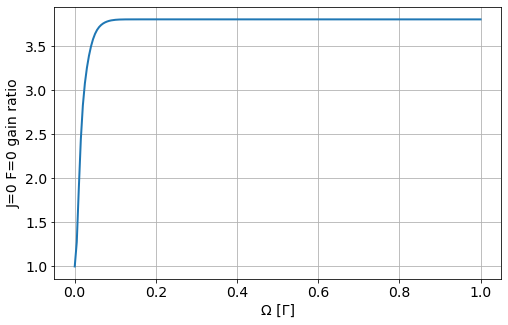

In [53]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, Main.sim[0], lw = 2)
ax.grid(True)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('J=0 F=0 gain ratio')
set_fontsize(ax, 14)

In [54]:
print(f"maximum gain {np.max(Main.sim[0]):.3f}")

maximum gain 3.803


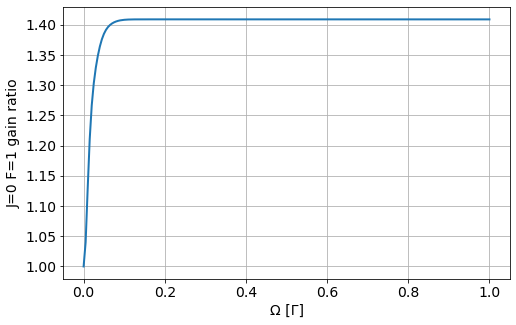

In [55]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, Main.sim[1], lw = 2)
ax.grid(True)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('J=0 F=1 gain ratio')
set_fontsize(ax, 14)

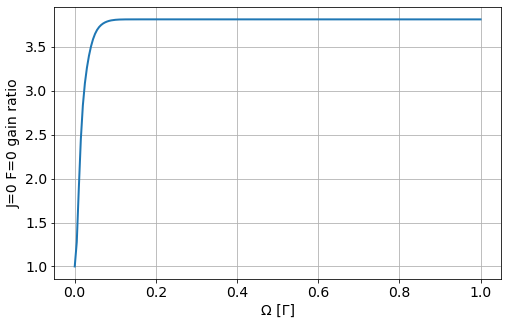

In [56]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, 3*0.337/0.147*(np.asarray(Main.sim[1])-1) + 1, lw = 2)
ax.grid(True)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('J=0 F=0 gain ratio')
set_fontsize(ax, 14)

### Changing Initial Temperature

In [57]:
ρ_scan = [] 
Ts = np.linspace(0.1,40,101)

for Ti in Ts:
    ρ = np.zeros(H_rot.shape, dtype = 'complex')

    index = 0
    for J in [0,2]:
        p = population(J, Ti)
        levels = J_levels(J)
        sl = np.s_[index:index+levels]
        np.fill_diagonal(ρ[sl, sl], p/levels)
        index += levels

    ρ /= np.diag(ρ).sum()
    ρ_scan.append(ρ)
    
Main.ρ_scan = ρ_scan
Main.eval("@everywhere ρ_scan = $ρ_scan")

In [58]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func_temp(prob,i,repeat)
    remake(prob,u0=ρ_scan[i])
end
""")

In [59]:
Main.eval("""
tspan = (0.0, 300e-6)
p = [0.2Γ, Δ, νmp, 0, 1]
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [60]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func_temp, output_func = output_func);
""");

In [61]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(ρ_scan)[1],
            abstol = 1e-9, reltol = 1e-6, save_everystep = false, dt = 1e-12, adaptive = true)
sim.elapsedTime
""")

6.2552798

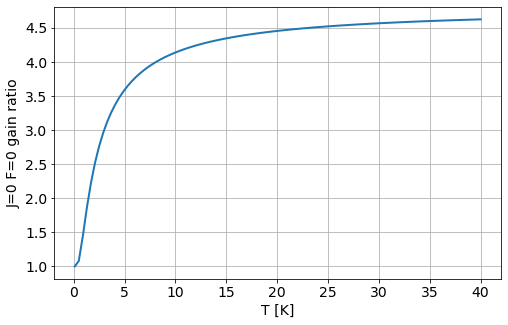

In [62]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts, Main.sim[0], lw = 2)
ax.grid(True)

ax.set_xlabel('T [K]')
ax.set_ylabel('J=0 F=0 gain ratio')
set_fontsize(ax, 14)

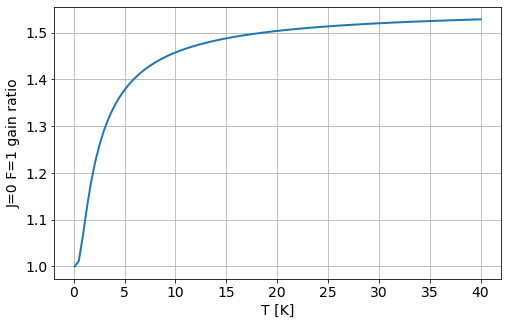

In [63]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts, Main.sim[1], lw = 2)
ax.grid(True)

ax.set_xlabel('T [K]')
ax.set_ylabel('J=0 F=1 gain ratio')
set_fontsize(ax, 14)

Text(0.5, 1.0, 'Maximum population transfer with pol. switching')

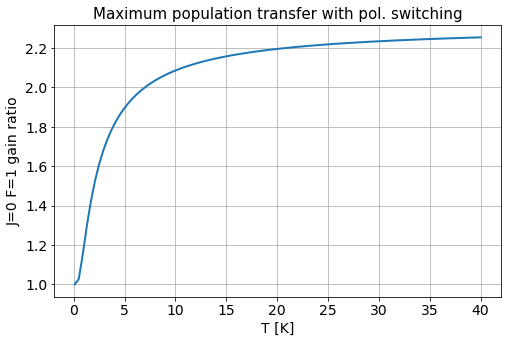

In [64]:
m_J0F1 = np.s_[1:4]
m_J2 = np.s_[4:24]

gains = []
for ρ in ρ_scan:
    F1_pop = np.diag(ρ)[m_J0F1].real.sum()
    J2_pop = np.diag(ρ)[m_J2].real.sum()
    J2_cooled = (13/20) * (0.147/(0.147+0.337)) * J2_pop
    gain = (F1_pop + J2_cooled) / F1_pop
    gains.append(gain)
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts, gains, lw = 2)
ax.grid(True)

ax.set_xlabel('T [K]')
ax.set_ylabel('J=0 F=1 gain ratio')
set_fontsize(ax, 14)
ax.set_title('Maximum population transfer with pol. switching', fontsize = 15)